In [5]:
import random
mapo = {
    0.1: list(range(0,11)),
    0.2: list(range(0,11)),
    0.3: list(range(0,11)),
    0.4: list(range(0,11)),
    0.5: list(range(0,11)),
    0.6: list(range(0,11)),
    0.7: list(range(0,11)),
    0.8: list(range(0,11)),
    0.9: list(range(0,11))
}

In [6]:
random.sample(list(mapo), 9)

[0.9, 0.6, 0.4, 0.1, 0.2, 0.5, 0.3, 0.7, 0.8]

In [7]:
mapo.values()

dict_values([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])

In [8]:
#!python
%matplotlib inline
from __future__ import print_function
import time

import numpy as np
from numpy import convolve as np_convolve
from scipy.signal import fftconvolve, lfilter, firwin
from scipy.signal import convolve as sig_convolve
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

In [2]:
# Create the m by n data to be filtered.
m = 1
n = 2 ** 18
x = np.random.random(size=(m, n))

conv_time = []
npconv_time = []
fftconv_time = []
conv1d_time = []
lfilt_time = []

diff_list = []
diff2_list = []
diff3_list = []

ntaps_list = 2 ** np.arange(2, 14)

for ntaps in ntaps_list:
    # Create a FIR filter.
    b = firwin(ntaps, [0.05, 0.95], width=0.05, pass_zero=False)

    # --- signal.convolve ---
    tstart = time.time()
    conv_result = sig_convolve(x, b[np.newaxis, :], mode='valid')
    conv_time.append(time.time() - tstart)

    # --- numpy.convolve ---
    tstart = time.time()
    npconv_result = np.array([np_convolve(xi, b, mode='valid') for xi in x])
    npconv_time.append(time.time() - tstart)

    # --- signal.fftconvolve ---
    tstart = time.time()
    fftconv_result = fftconvolve(x, b[np.newaxis, :], mode='valid')
    fftconv_time.append(time.time() - tstart)

    # --- convolve1d ---
    tstart = time.time()
    # convolve1d doesn't have a 'valid' mode, so we expliclity slice out
    # the valid part of the result.
    conv1d_result = convolve1d(x, b)[:, (len(b)-1)//2 : -(len(b)//2)]
    conv1d_time.append(time.time() - tstart)

    # --- lfilter ---
    tstart = time.time()
    lfilt_result = lfilter(b, [1.0], x)[:, len(b) - 1:]
    lfilt_time.append(time.time() - tstart)

    diff = np.abs(fftconv_result - lfilt_result).max()
    diff_list.append(diff)

    diff2 = np.abs(conv1d_result - lfilt_result).max()
    diff2_list.append(diff2)

    diff3 = np.abs(npconv_result - lfilt_result).max()
    diff3_list.append(diff3)

# Verify that np.convolve and lfilter gave the same results.
print("Did np.convolve and lfilter produce the same results?",)
check = all(diff < 1e-13 for diff in diff3_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

# Verify that fftconvolve and lfilter gave the same results.
print( "Did fftconvolve and lfilter produce the same results?")
check = all(diff < 1e-13 for diff in diff_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

# Verify that convolve1d and lfilter gave the same results.
print( "Did convolve1d and lfilter produce the same results?",)
check = all(diff2 < 1e-13 for diff2 in diff2_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")


Did np.convolve and lfilter produce the same results?
Yes.
Did fftconvolve and lfilter produce the same results?
Yes.
Did convolve1d and lfilter produce the same results?
Yes.


In [9]:
def timeit(fn, shape, lfilter=False, n_x=2e4, repeats=3):
    x = np.random.rand(int(n_x))
    y = np.random.rand(*shape)
    args = [x, y] if not lfilter else [x, x, y]
    times = []
    for _ in range(int(repeats)):
        start = time.time()
        c = fn(*args)
        times += [time.time() - start]
    return min(times)

npconv_time2, conv_time2, conv1d_time2 = [], [], []
fftconv_time2, sig_conv_time2, lconv_time2 = [], [], []
Ns_1d = 2*np.logspace(0, 4, num=11, dtype=int)
for n in Ns_1d:
    npconv_time2 += [timeit(np_convolve, shape=(n,))]
    conv1d_time2 += [timeit(convolve1d, shape=(n,))]
    fftconv_time2 += [timeit(fftconvolve, shape=(n,))]
    sig_conv_time2 += [timeit(sig_convolve, shape=(n,))]
    lconv_time2 += [timeit(lfilter, shape=(n,), lfilter=True)]

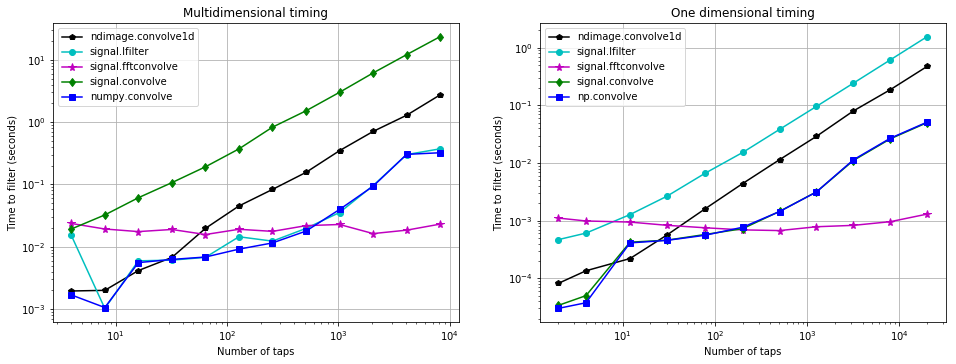

In [10]:
fig = plt.figure(1, figsize=(16, 5.5))
plt.subplot(1, 2, 1)
plt.loglog(ntaps_list, conv1d_time, 'k-p', label='ndimage.convolve1d')
plt.loglog(ntaps_list, lfilt_time, 'c-o', label='signal.lfilter')
plt.loglog(ntaps_list, fftconv_time, 'm-*', markersize=8, label='signal.fftconvolve')
plt.loglog(ntaps_list[:len(conv_time)], conv_time, 'g-d', label='signal.convolve')
plt.loglog(ntaps_list, npconv_time, 'b-s', label='numpy.convolve')
plt.legend(loc='best', numpoints=1)
plt.grid(True)
plt.xlabel('Number of taps')
plt.ylabel('Time to filter (seconds)')
plt.title('Multidimensional timing')

plt.subplot(1, 2, 2)
plt.loglog(Ns_1d, conv1d_time2, 'k-p', label='ndimage.convolve1d')
plt.loglog(Ns_1d, lconv_time2, 'c-o', label='signal.lfilter')
plt.loglog(Ns_1d, fftconv_time2, 'm-*', markersize=8, label='signal.fftconvolve')
plt.loglog(Ns_1d, sig_conv_time2, 'g-d', label='signal.convolve')
plt.loglog(Ns_1d, npconv_time2, 'b-s', label='np.convolve')
plt.grid()
plt.xlabel('Number of taps')
plt.ylabel('Time to filter (seconds)')
plt.title('One dimensional timing')
plt.legend(loc='best')
plt.show()

In [20]:
lfilt_result[0].size

253953

In [66]:
from scipy import signal
order = 80
sampleRate = 44100
frequency = 8820

lowcut = frequency - 1000
highcut = frequency + 1000

b = signal.firwin(order, [lowcut, highcut], pass_zero=False, nyq=sampleRate/2)
w, h = signal.freqz(b)

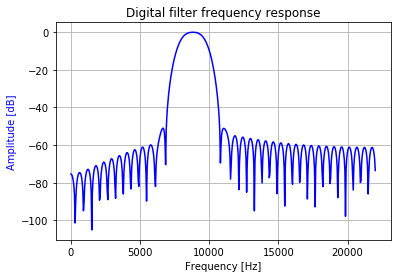

In [69]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title('Digital filter frequency response')

plt.plot((sampleRate * 0.5 / np.pi) * w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')

plt.grid()
plt.axis('tight')
plt.show()

In [65]:
h

array([  1.70540808e-04 +0.00000000e+00j,
         1.61747892e-04 -3.99887691e-05j,
         1.37152722e-04 -7.22311869e-05j,
         1.01753971e-04 -9.05326285e-05j,
         6.27762521e-05 -9.15002921e-05j,
         2.82328350e-05 -7.52461689e-05j,
         5.31694730e-06 -4.53999119e-05j,
        -1.06468334e-06 -8.41952695e-06j,
         1.06759521e-05 +2.76763652e-05j,
         3.84242073e-05 +5.49152880e-05j,
         7.67196318e-05 +6.70042111e-05j,
         1.17802367e-04 +6.06620442e-05j,
         1.53158559e-04 +3.63727760e-05j,
         1.75266837e-04 -1.61318132e-06j,
         1.79195230e-04 -4.60563985e-05j,
         1.63713613e-04 -8.81535780e-05j,
         1.31671647e-04 -1.19340224e-04j,
         8.95330335e-05 -1.33109790e-04j,
         4.61281049e-05 -1.26467586e-04j,
         1.08543492e-05 -1.00695987e-04j,
        -8.31702333e-06 -6.12373083e-05j,
        -6.61086336e-06 -1.66791918e-05j,
         1.63967746e-05 +2.29808014e-05j,
         5.65165916e-05 +4.8449935